In [10]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

DATA_PROCESSED = Path("../data/processed")

X = pd.read_parquet(DATA_PROCESSED / "X_encoded.parquet")
y = pd.read_parquet(DATA_PROCESSED / "y_target.parquet")["target"]
X_train_bal = pd.read_parquet(DATA_PROCESSED / "X_train_bal.parquet")
y_train_bal = pd.read_parquet(DATA_PROCESSED / "y_train_bal.parquet")["target"]

# même split que notebook 4
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)
print(y_train.value_counts(normalize=True))


Train: (1176, 42) Test: (294, 42)
target
0    0.838435
1    0.161565
Name: proportion, dtype: float64


In [11]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

log_pipeline = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, random_state=42))
])

param_grid_log = {
    "model__solver": ["liblinear"],
    "model__C": [0.01, 0.1, 1, 10],
    "model__penalty": ["l1", "l2"],
}

grid_log = GridSearchCV(
    estimator=log_pipeline,
    param_grid=param_grid_log,
    scoring="recall",
    cv=cv,
    n_jobs=-1
)

grid_log.fit(X_train, y_train)
print("Best params (Logistic):", grid_log.best_params_)


Best params (Logistic): {'model__C': 0.01, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


In [12]:
rf_pipeline = Pipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("model", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5],
    "model__class_weight": ["balanced", "balanced_subsample"]
}

grid_rf = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    scoring="recall",
    cv=cv,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("Best params (RandomForest):", grid_rf.best_params_)


Best params (RandomForest): {'model__class_weight': 'balanced_subsample', 'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}



🔹 Logistique
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       247
           1       0.48      0.53      0.51        47

    accuracy                           0.83       294
   macro avg       0.69      0.71      0.70       294
weighted avg       0.84      0.83      0.84       294



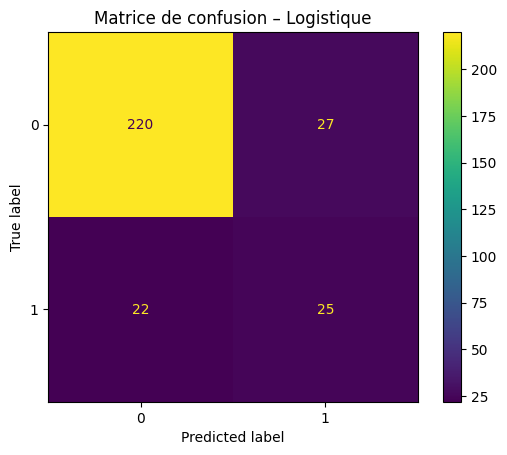


🔹 RandomForest
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       247
           1       0.50      0.53      0.52        47

    accuracy                           0.84       294
   macro avg       0.70      0.72      0.71       294
weighted avg       0.84      0.84      0.84       294



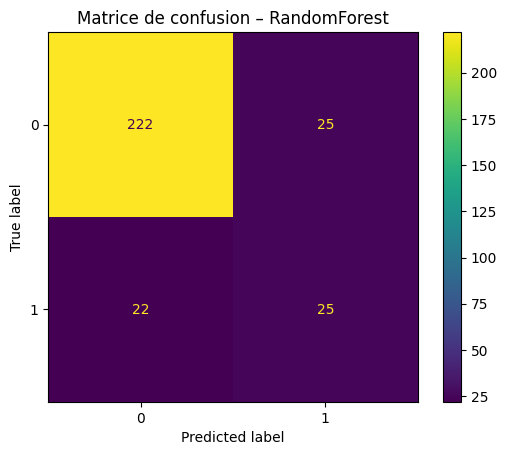

In [13]:
best_log = grid_log.best_estimator_
best_rf = grid_rf.best_estimator_

y_pred_log = best_log.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

for name, y_pred in {"Logistique": y_pred_log, "RandomForest": y_pred_rf}.items():
    print(f"\n🔹 {name}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title(f"Matrice de confusion – {name}")
    plt.show()


In [14]:
# Explainer pour le modèle Random Forest (arbre)
rf_model = best_rf.named_steps["model"]  # récupère le modèle entraîné à l’intérieur du pipeline
explainer = shap.TreeExplainer(rf_model)

# Sélection d’un sous-échantillon pour accélérer
X_shap = X_train_bal.sample(500, random_state=42)
shap_values = explainer.shap_values(X_shap)

print(f"✅ SHAP prêt : {X_shap.shape[0]} lignes et {X_shap.shape[1]} features.")


✅ SHAP prêt : 500 lignes et 42 features.


✅ shap_class1 shape: (500, 42)
expl shape: (500, 42)


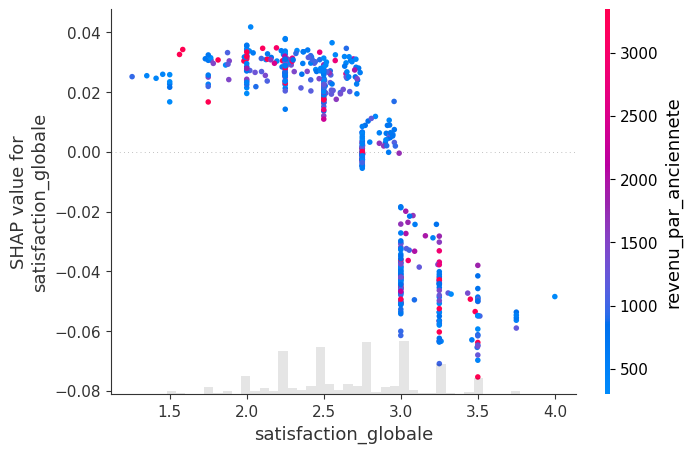

Impact SHAP : Satisfaction globale (colorée par revenu par ancienneté)


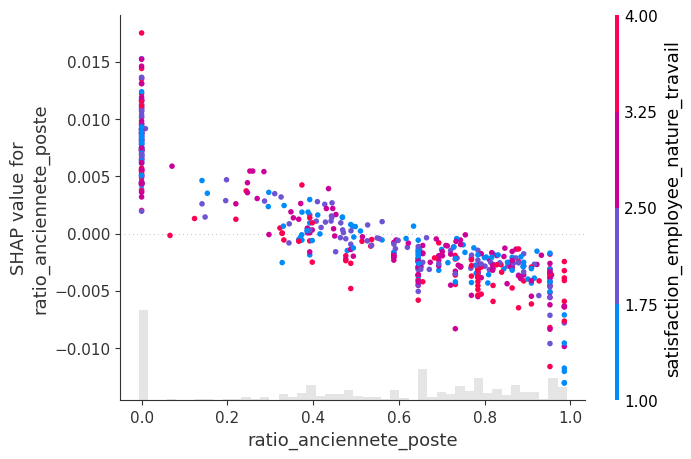

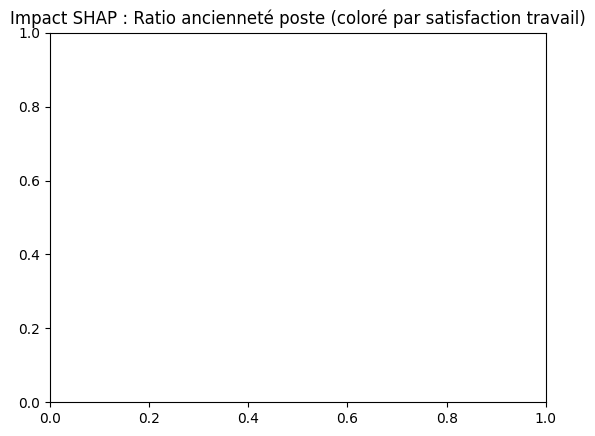

In [42]:
# ─── Correction de la dimension (on garde la classe positive uniquement) ───────
shap_class1 = shap_values[:, :, 1]  # on sélectionne la classe 1 (colonne 1)
print("✅ shap_class1 shape:", shap_class1.shape)

# ─── Construction de l'objet Explanation ───────────────────────────────────────
expl = shap.Explanation(
    values=shap_class1,
    base_values=np.full(len(X_shap), explainer.expected_value[1]),
    data=X_shap.values,
    feature_names=X_shap.columns
)

print("expl shape:", expl.shape)

# ─── Visualisation SHAP scatter ────────────────────────────────────────────────
shap.plots.scatter(
    expl[:, "satisfaction_globale"],
    color=expl[:, "revenu_par_anciennete"]
)
print("Impact SHAP : Satisfaction globale (colorée par revenu par ancienneté)")
plt.show()

# 2️⃣ Scatter plot SHAP : Ratio ancienneté dans le poste (feature créée)
#    Coloré par satisfaction nature du travail
shap.plots.scatter(
    expl[:, "ratio_anciennete_poste"],
    color=expl[:, "satisfaction_employee_nature_travail"]
)
plt.title("Impact SHAP : Ratio ancienneté poste (coloré par satisfaction travail)")
plt.show()


In [16]:
# Extraire les shap values pour la classe "départ" (classe 1)
if isinstance(shap_values, list):
    shap_class1 = shap_values[1]
    # si shap_values est en (n_samples, n_features, k) on le réduit en (n_samples, n_features)
    if shap_class1.ndim == 3:
        shap_class1 = shap_class1[:, :, 0]
else:
    shap_class1 = shap_values  # déjà 2D normalement

print("shap_class1 shape:", getattr(shap_class1, "shape", None))
print("X_shap shape:", X_shap.shape)
print("Colonnes dispo :", list(X_shap.columns[:10]), "...")  # on affiche juste les 10 premières
# Réduction du tableau SHAP 3D vers 2D pour la classe "départ"
shap_class1 = shap_class1[:, :, 0]

print("✅ shap_class1 réduit à :", shap_class1.shape)


shap_class1 shape: (500, 42, 2)
X_shap shape: (500, 42)
Colonnes dispo : ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe'] ...
✅ shap_class1 réduit à : (500, 42)


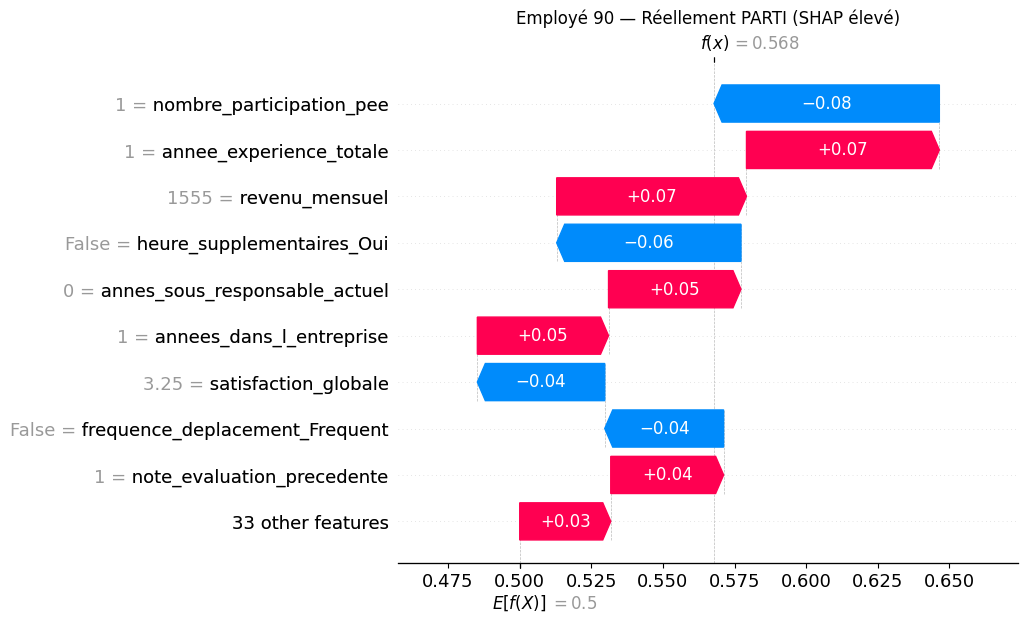

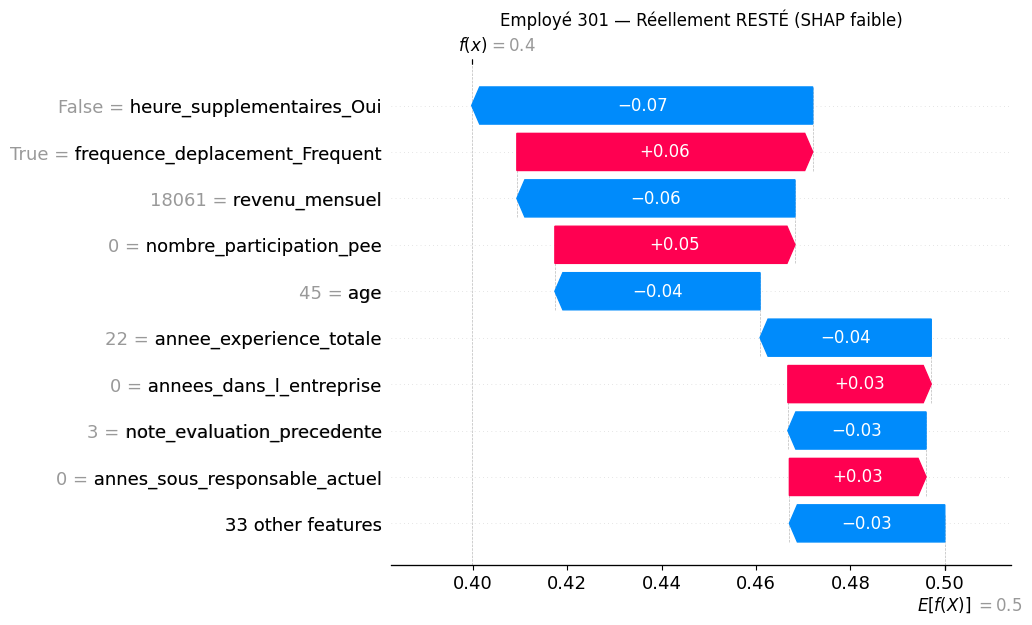

In [21]:
# ───────────────────────────────────────────────
# Sélection correcte des individus pour SHAP Waterfall
# ───────────────────────────────────────────────

# On échantillonne X et y de manière cohérente
sample = X_train_bal.sample(500, random_state=42)
X_shap = sample
y_shap = y_train_bal.loc[sample.index]

# Indices des employés réellement partis et restés
indices_positive = np.where(y_shap == 1)[0]
indices_negative = np.where(y_shap == 0)[0]

# 1️⃣ Individu réellement parti avec SHAP le plus élevé
idx_high = indices_positive[np.argmax(shap_values[indices_positive, 1, 1])]

# 2️⃣ Individu réellement resté avec SHAP le plus négatif
idx_low = indices_negative[np.argmin(shap_values[indices_negative, 1, 1])]

# Explications SHAP pour haute proba
sample_high = X_shap.iloc[idx_high]
explanation_high = shap.Explanation(
    values=shap_values[idx_high, :, 1],
    base_values=explainer.expected_value[1],
    data=sample_high,
    feature_names=X_shap.columns
)

plt.title(f"Employé {idx_high} — Réellement PARTI (SHAP élevé)")
shap.plots.waterfall(explanation_high, max_display=10)

# Explications SHAP pour faible proba
sample_low = X_shap.iloc[idx_low]
explanation_low = shap.Explanation(
    values=shap_values[idx_low, :, 1],
    base_values=explainer.expected_value[1],
    data=sample_low,
    feature_names=X_shap.columns
)

plt.title(f"Employé {idx_low} — Réellement RESTÉ (SHAP faible)")
shap.plots.waterfall(explanation_low, max_display=10)


C:\Users\daniel.guedj_arondor\AppData\Local\Temp\ipykernel_2828\1167449038.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


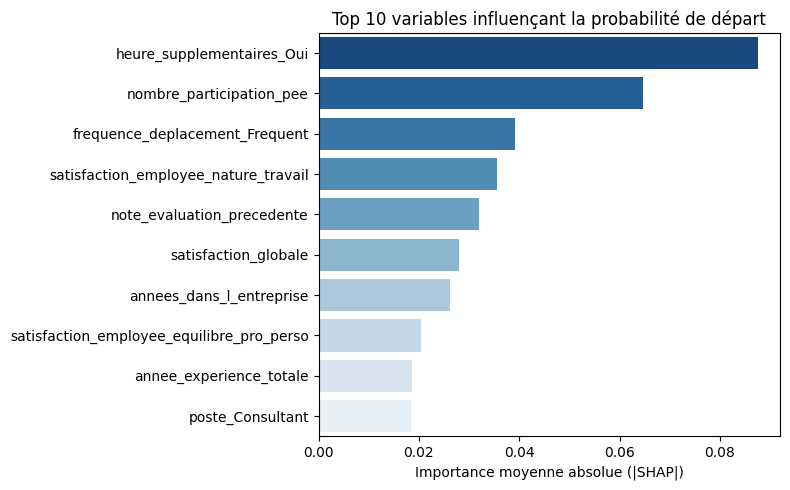

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ─── Importance globale (moyenne absolue des valeurs SHAP) ───────────────
shap_importance = np.abs(shap_values[:, :, 1]).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X_shap.columns,
    "Mean |SHAP value|": shap_importance
}).sort_values(by="Mean |SHAP value|", ascending=False)

# ─── Graphique barres horizontales ───────────────────────────────────────
plt.figure(figsize=(8,5))
sns.barplot(
    y="Feature",
    x="Mean |SHAP value|",
    data=importance_df.head(10),
    palette="Blues_r"
)
plt.title("Top 10 variables influençant la probabilité de départ")
plt.xlabel("Importance moyenne absolue (|SHAP|)")
plt.ylabel("")
plt.tight_layout()
plt.show()
